# Zomboids

- From Zane Rankin
- To Nerds
- 2/1/2018

In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
pd.set_option('display.max_rows', 8)
%matplotlib inline
!date

Thu Feb  1 15:46:31 PST 2018


In [2]:
import vivarium, vivarium.test_util as vtu

np.random.seed(12345)  # set random seed for reproducibility

n_simulants = 200
t_timestep = 1 # days
t_start = pd.Timestamp('1990-01-01')
boxsize = 1

# Option 1 - "geospatial disease model"

In [3]:
from vivarium.framework.event import listens_for
from vivarium.framework.population import uses_columns

class Zombies:
    def setup(self, builder):
        self.population_view = builder.population_view(['x', 'y', 'vx', 'vy', 'infected'])
        
    @listens_for('initialize_simulants', priority=0)
    def do_initalize_simulants(self, event):
        """Start new simulants with a random location and random direction
        """
        pop = pd.DataFrame(index=event.index)

        pop['x'] = np.random.uniform(0, boxsize, size=len(pop))
        pop['y'] = np.random.uniform(0, boxsize, size=len(pop))

        pop['vx'] = 0 # .1*np.random.uniform(size=len(pop))
        pop['vy'] = 0 # .1*np.random.uniform(size=len(pop))
        
        #pop['infected'] = (0 + 0.55 * np.random.uniform(size=len(pop))).round().astype(int)

        #just one infected person?
        pop['infected'] = 0
        pop.infected[0] = 1
        
        # update the population in the model
        self.population_view.update(pop)

In [4]:
def d(df, i, j):
    """convenience function to calculate the distance between i and j in dataframe df"""
    dx = df.x[i] - df.x[j]
    dy = df.y[i] - df.y[j]
    return np.sqrt(dx*dx + dy*dy)

In [5]:
class InfectNeighbor:
    @listens_for('time_step')
    @uses_columns(['x', 'y', 'infected'])
    def on_time_step(self, event):
        
        df = event.population
        
        #TODO make distance an argument - right now 0.05 (or 5% of boxsize) seems reasonable
        proximity = 0.05
        
        #TODO need to make more efficient, ie avoid looping through all individuals. 
        #Maybe try to get a proximity function that only has to loop over neighbors
        for i in range(len(df)): #loop through individuals
            if df.infected[i]:
                for j in range(len(df)): #loop through others
                    if not df.infected[j]:
                        if d(df, i, j) < proximity: df.infected[j] = 1
        event.population_view.update(df)

In [6]:
class SavePop:
    @listens_for('initialize_simulants', priority = 1)
    def start_output_hdf(self, event):
        d = {'time': [0], 'prev': [1/n_simulants], 'inc': [0]}
        output = pd.DataFrame(data=d)
        output.to_hdf('output.hdf', key = 'zombies')
    
    @listens_for('time_step')
    @uses_columns(['x', 'y', 'infected'])
    def on_time_step(self, event):
        df = event.population
        output = pd.read_hdf('output.hdf')
        
        t_prev = output.time.max()
        d = {'time': t_prev + 1, 'prev': [df.infected.mean()], 'inc': [df.infected.mean() - output.prev.max()]}
        out = pd.DataFrame(data=d)
        
        output = pd.concat([output, out])
        output.to_hdf('output.hdf', key = 'zombies')

In [7]:
def keepenclosed(df, boxsize):
    """convenience function to keep individuals within box"""
    df.loc[df.x > boxsize, 'x'] = boxsize
    df.loc[df.y > boxsize, 'y'] = boxsize
    df.loc[df.x < 0, 'x'] = 0
    df.loc[df.y < 0, 'y'] = 0

In [8]:
class ZombieRoam:
    @listens_for('time_step')
    @uses_columns(['x', 'y', 'infected'])
    def on_time_step(self, event):
        
        df = event.population
        
        df.loc[df.infected == 1, 'x'] += np.random.uniform(-0.1, 0.1, size=len(df.loc[df.infected == 1]))
        df.loc[df.infected == 1, 'y'] += np.random.uniform(-0.1, 0.1, size=len(df.loc[df.infected == 1]))
        
        keepenclosed(df, boxsize)
        
        event.population_view.update(df)

In [9]:
class EveryoneWander:
    @listens_for('time_step')
    @uses_columns(['x', 'y', 'infected'])
    def on_time_step(self, event):
        
        df = event.population
        
        df.x += np.random.uniform(-0.1, 0.1, size=len(df))
        df.y += np.random.uniform(-0.1, 0.1, size=len(df))
        
        #Constrain to box
        keepenclosed(df, boxsize)
        
        event.population_view.update(df)

/home/james/miniconda3/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


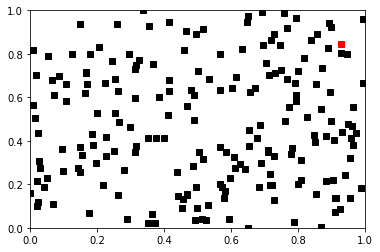

In [10]:
def my_plot(df):
    plt.plot(df[df['infected'] == 0].x, df[df['infected'] == 0].y, 'ks')
    plt.plot(df[df['infected'] == 1].x, df[df['infected'] == 1].y, 'ks', c = 'r')
    plt.axis(xmin=0, ymin=0, xmax=1, ymax=1)


sim = vtu.setup_simulation([Zombies(), ZombieRoam(), InfectNeighbor(), SavePop()], population_size=n_simulants, start=t_start)
df = sim.population.population  # a copy of the population table
#sns.lmplot('x', 'y', hue = 'infected', fit_reg=False, data = df)
my_plot(df)

In [11]:
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=pd.Timedelta(days=5))

VBox(children=(HTML(value=''), IntProgress(value=0, max=5)))

/home/james/miniconda3/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5

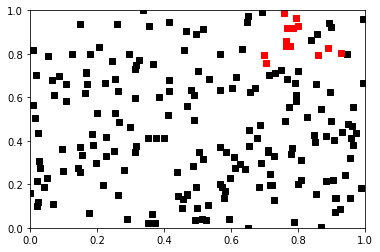

In [12]:
df = sim.population.population  # a copy of the population table
my_plot(df)

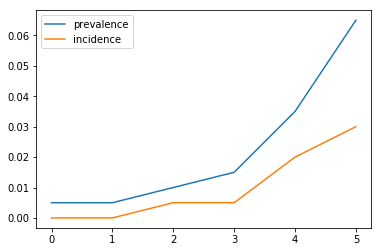

In [13]:
def plot_output(df):
    plt.plot('time', 'prev', data = df, label = 'prevalence')
    plt.plot('time', 'inc', data = df, label = 'incidence')
    plt.legend()
output = pd.read_hdf('output.hdf')
plot_output(output)

# Make a movie!

In [14]:
from matplotlib import animation
from IPython.display import HTML

class MovieWriter:
    def __init__(self, fname):
        self.moviewriter = animation.ImageMagickWriter(fps=2)
        self.fname = fname
            
    def __enter__(self):
        fig = plt.figure()
        self.moviewriter.setup(fig, self.fname, dpi=100)
        return self
    
    def setup(self, builder):
        self.population_view = builder.population_view(['x', 'y', 'vx', 'vy', 'infected'])
        
    @listens_for('collect_metrics')
    def on_collect_metrics(self, event):
        pop = self.population_view.get(event.index)
        
        plt.clf()
        my_plot(pop)

        self.moviewriter.grab_frame()

    def __exit__(self, exception_type, exception_value, traceback):
        self.moviewriter.finish()


In [15]:
def plot_output(df):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot('time', 'prev', data = df, label = 'prevalence')
    plt.plot('time', 'inc', data = df, label = 'incidence')
    plt.legend()
    fig.savefig('incprev.png', dpi=300)

/home/james/miniconda3/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


VBox(children=(HTML(value=''), IntProgress(value=0, max=26)))

/home/james/miniconda3/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


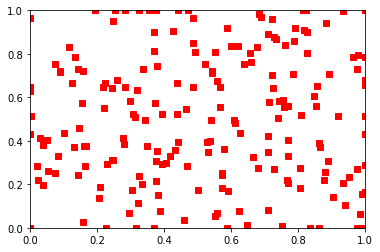

In [16]:
with MovieWriter('roaming.gif') as mw:
    sim = vtu.setup_simulation([Zombies(), ZombieRoam(), InfectNeighbor(), SavePop(), mw],
                               population_size=n_simulants, start=t_start)
    vtu.pump_simulation(sim, time_step_days=t_timestep, duration=26)

HTML('<img src="roaming.gif">')

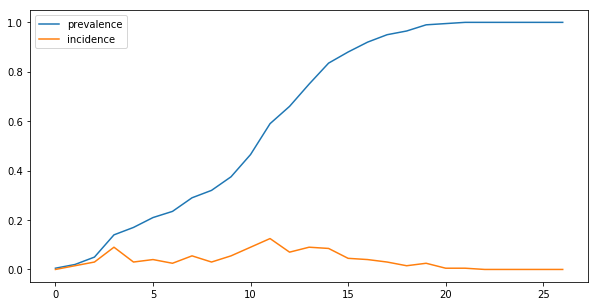

In [17]:
output = pd.read_hdf('output.hdf')
plot_output(output)

# TODO
- add remission or treatment or vaccine
- CEAM_PUBLIC_HEALTH DISEASE MODEL?
- clustering of positions, flocking behavior, etc
- healthy people run from zombies